# Assignment #2
## Introduction
- **Objective:** Enhance the classification model previously built in the session to predict loan defaults using the Lending Club dataset. Please use the 100k row sample as starting point for your model. 
---

 ### **Notebook Structure:**
- 0. Import Data

- 1. Feature Selection & Engineering
    - 1.0 Legacy/ Initial model with initial features
    - 1.1 Feature Selection (Selecting additional variables)
    - 1.2 Feature Engineering
- 2. Data Splitting
- 3. Model_2 Selection & RFE 
- 4. Cross-Validation 
    - 4.1 Legacy model
    - 4.2 New Model_2
- 5. Hyperparameter finetuning Model_2 with selected features
    - 5.1 GridSearchCV to find best parameters
    - 5.2 Check if the model overfits
        - Finetune parameters of model to not overfit
- 6. Model Evaluations & Comparisons
 
- Part 2. Custom Loss Function Implementation and Optimisation (Optional)
- Part 3. PoC to Predict 'loan_amnt' using a regression model (Optional)
---



### Import libraries

In [ ]:
## Just testing these packages in (base) environment
import pandas as pd
import numpy as np

import yfinance as yf

from tensorflow.keras.layers import LSTM
import streamlit as st

In [240]:
# Standard Libraries
import pandas as pd
import numpy as np

pd.set_option('max_colwidth', 800)
pd.set_option('display.max_columns', None)

# Working locally on Jupyter Notebook, parent folder is one folder up (using the folder structure shared at the beginning of the course)
path_python_material = ".."

---
# 0. Import Data

In [241]:
# Read data that was exported from previous session
df = pd.read_csv(f"{path_python_material}/data/2-intermediate/df_out_dsif5.csv")

# print shape of dataFrame
(print(f"shape of df = {df.shape}"))

df.head()

shape of df = (100000, 160)


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,hardship_status_filled,last_pymnt_amnt_log,last_pymnt_amnt_capped,loan_id_extracted,emp_title_clean,emp_title_manager,Job Title,Category,int_rate_clean,interest_per_loan_amnt,term_numeric,debt_to_income,loan_amnt_log,grade_encoded,loan_amnt_std,annual_inc_std,loan_amnt_norm,annual_inc_norm,loan_default
0,167338079,4000.0,4000.0,4000.0,36 months,13.08,134.93,B,B5,cashier,10+ years,MORTGAGE,48000.0,Source Verified,Mar-2020,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=167338079,home_improvement,Home improvement,115xx,NY,20.25,1.0,Dec-2004,665.0,669.0,0.0,19.0,110.0,4.0,1.0,1988.0,82.8%,12.0,w,3816.34,3816.34,266.950000,266.95,183.66,83.29,0.0,0.0,0.0,May-2020,134.93,Jun-2020,May-2020,669.0,665.0,1.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,3832.0,259024.0,0.0,1.0,0.0,1.0,16.0,9960.0,56.0,0.0,0.0,0.0,59.0,2400.0,1.0,0.0,0.0,1.0,64756.0,NaN,NaN,0.0,0.0,179.0,75.0,38.0,16.0,2.0,NaN,19.0,16.0,19.0,1.0,0.0,2.0,0.0,1.0,5.0,2.0,5.0,2.0,4.0,0.0,0.0,0.0,0.0,75.0,NaN,1.0,0.0,395328.0,11948.0,0.0,17928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO_HARDSHIP,4.912140,134.93,167338079,cashier,False,NaN,NaN,13.08,156960.0,36.0,0.083333,8.294300,1,-1.196895,-0.367206,0.083969,0.004364,False
1,71016917,24000.0,24000.0,24000.0,60 months,9.16,500.07,B,B2,ABM,6 years,RENT,57000.0,Source Verified,Feb-2016,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=71016917,credit_card,Credit card refinancing,708xx,LA,25.33,0.0,Jan-2004,680.0,684.0,0.0,NaN,NaN,10.0,0.0,22697.0,64.5%,24.0,w,4333.29,4333.29,25496.160000,25496.16,19666.71,5829.45,0.0,0.0,0.0,May-2020,500.07,Jun-2020,May-2020,704.0,700.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,61815.0,0.0,3.0,0.0,3.0,14.0

In [242]:
df.loan_status.value_counts()

Fully Paid                                             51189
Current                                                35294
Charged Off                                            12384
Late (31-120 days)                                       535
In Grace Period                                          329
Late (16-30 days)                                         90
Does not meet the credit policy. Status:Fully Paid        69
Issued                                                    63
Does not meet the credit policy. Status:Charged Off       33
Default                                                   14
Name: loan_status, dtype: int64

#### Define target variable

*Useful definitions:*  
- *Defaulted Loan: A loan is considered in default when the borrower fails to make the required payments as agreed in the loan contract. Default typically occurs after missing several payments (usually 90 to 180 days, depending on the type of loan and lender policies).*

- *A loan is charged off when the lender writes off the loan as a bad debt on their financial statements, recognizing it as a loss. This typically happens after the loan has been in default for a significant period, often around 180 days.*


In [243]:
df['loan_default'] = df.loan_status == "Charged Off"
df['loan_default'].value_counts()


False    87616
True     12384
Name: loan_default, dtype: int64

#### Observation
- We can see there are ~12% of default loans

---
# 1. Feature Selection & Engineering

## 1.1 Feature Selection:

- Legacy Model/Initial Features:
    - 'fico_range_high', 
    - 'fico_range_low', 
    - 'annual_inc', 
    - 'dti' = A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

- New Model_2 / Additional Features added that can potentially relate to loan_defaults:
    - 'annual_inc' = Annual income, indicator if they can afford to pay back the loan or not.
    - 'debt_to_income' = Ratio between 'loan_amnt and annual_inc. This does NOT! equate to 'dti',
    - 'total_bc_limit' = Total Bank Card high credit/ credit limit ~ a borrower's credit limit can entail if they have enough credit to make payments or not,
    - 'total_rec_late_fee' = Late fees received to date ~ late payment fees leads to more debt (i.e., bad debt), hence can lead to missing other payments,
    - 'int_rate_clean' = Interest rate can be a factor, hence high interest rate can lead to more difficulties in paying off a loan,
    - 'term' = Length to pay back the loan can show a categorical relationship, values are [36, 60 months] (might be too short for some with high interest and low annual_income),
    - 'loan_amnt' = loan_amount received, 
    - 'purpose' = ' Purpose of the loan, can show a categorical relationships, i.e., which purposes are most likely to lead to a loan_default, 
    - 'home_ownership' = Home_onwership status, can show a categorical relationships, i.e., does being a Renter or having a high mortgage lead to missing payments ? 


## 1.2 Feature Engineering:
- Handle NaN and inf values
- StandardScaler transform all numerical variables (Standarise the variables to be on equal footing)
- OneHotEncode transform categorical variables (hence, assigning a numerical value to a category)




---
### 1.0 Legacy/ Initial model with initial features

In [244]:
# Legacy Model/Initial Features

# 1.1 Feature Selection

# Feature section legacy (for simple 'model')
features = ['fico_range_high', 'fico_range_low', 'annual_inc', 'dti']
X = df[features]
y = df['loan_default']

# 1.2 Feature Engineering

# Initialize and train the Logistic Regression model
from sklearn.impute import SimpleImputer

# LogisticRegression model in scikit-learn cannot handle missing values represented as NaN (Not a Number), hence replacing
# Create an imputer (replace missing values with the mean of the column)
imputer = SimpleImputer(strategy='mean')

# What pandas method did we see previously to accomplish this?
# ANSWER - Session 2. # Imputation: Filling missing values with the mean for numerical columns

# Fit the imputer
X = imputer.fit_transform(X)

df[features + ['loan_default']].head()

,fico_range_high,fico_range_low,annual_inc,dti,loan_default
0,669.0,665.0,48000.0,20.25,False
1,684.0,680.0,57000.0,25.33,False
2,669.0,665.0,55000.0,7.22,False
3,754.0,750.0,43500.0,24.55,False
4,739.0,735.0,48000.0,24.30,False


---
### 1.1 Feature Selection for New Model_2:

- We know there are outliers lurking within the 'annual_income' == 0, field, which causes 'debt_to_income' to have values = inf, and dti = NaN
- Also, need to perform checks on our categorical data, to ensure they are all populated



In [245]:
# Select few features for NEW.! model_2

# 1.1 Feature Selection
# Splitting up the variables in two list, one for numeric, one for categorical

features_num = [
    'fico_range_high', 
    'fico_range_low', 
    'annual_inc', 
    'dti',
    'debt_to_income',
    'total_bc_limit',
    'total_rec_late_fee',
    'int_rate_clean',
    'loan_amnt', 
    ]

# Categorical variables
features_cat = [
    'term', 
    'purpose', 
    'home_ownership'
    ]

# New Dataframe for model_2
df_model_2 = df[features_num + features_cat + ['loan_default']].copy()

# Looking at the number of records with annual_inc == 0, 'debt_to_income = inf, dti = NaN

print(" \n Quick stats for debt_to_income = inf")
display(df_model_2[df_model_2['debt_to_income'] == np.inf].describe())

print("\n Quick stats for annual_inc = 0")
display(df_model_2[df_model_2['annual_inc'] < 1 ].describe())

print("\n Quick stats for dti = NaN")
display(df_model_2[pd.isnull(df_model_2['dti']) == True ].describe())

 
 Quick stats for debt_to_income = inf


c:\Users\cpitt\anaconda3\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,fico_range_high,fico_range_low,annual_inc,dti,debt_to_income,total_bc_limit,total_rec_late_fee,int_rate_clean,loan_amnt
count,100.000000,100.000000,100.0,1.0,100.0,100.000000,100.000000,100.00000,100.000000
mean,717.900000,713.900000,0.0,0.0,inf,35897.000000,2.442500,14.21410,20953.250000
std,37.393485,37.393485,0.0,NaN,NaN,55974.343789,12.269828,5.82049,11363.189648
min,664.000000,660.000000,0.0,0.0,inf,500.000000,0.000000,6.11000,2500.000000
25%,684.000000,680.000000,0.0,0.0,NaN,7825.000000,0.000000,10.07750,11900.000000
50%,711.500000,707.500000,0.0,0.0,NaN,22150.000000,0.000000,13.73000,20500.000000
75%,749.000000,745.000000,0.0,0.0,NaN,36650.000000,0.000000,18.95250,29100.000000
max,804.000000,800.000000,0.0,0.0,inf,369500.000000,90.980002,30.65000,40000.000000



 Quick stats for annual_inc = 0


c:\Users\cpitt\anaconda3\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,fico_range_high,fico_range_low,annual_inc,dti,debt_to_income,total_bc_limit,total_rec_late_fee,int_rate_clean,loan_amnt
count,100.000000,100.000000,100.0,1.0,100.0,100.000000,100.000000,100.00000,100.000000
mean,717.900000,713.900000,0.0,0.0,inf,35897.000000,2.442500,14.21410,20953.250000
std,37.393485,37.393485,0.0,NaN,NaN,55974.343789,12.269828,5.82049,11363.189648
min,664.000000,660.000000,0.0,0.0,inf,500.000000,0.000000,6.11000,2500.000000
25%,684.000000,680.000000,0.0,0.0,NaN,7825.000000,0.000000,10.07750,11900.000000
50%,711.500000,707.500000,0.0,0.0,NaN,22150.000000,0.000000,13.73000,20500.000000
75%,749.000000,745.000000,0.0,0.0,NaN,36650.000000,0.000000,18.95250,29100.000000
max,804.000000,800.000000,0.0,0.0,inf,369500.000000,90.980002,30.65000,40000.000000


c:\Users\cpitt\anaconda3\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)



 Quick stats for dti = NaN


,fico_range_high,fico_range_low,annual_inc,dti,debt_to_income,total_bc_limit,total_rec_late_fee,int_rate_clean,loan_amnt
count,102.000000,102.000000,102.000000,0.0,102.0,102.000000,102.000000,102.000000,102.000000
mean,717.333333,713.333333,0.029412,NaN,inf,35178.431373,2.394608,14.133824,21034.558824
std,37.213149,37.213149,0.169792,NaN,NaN,55404.754822,12.152503,5.800030,11279.361050
min,664.000000,660.000000,0.000000,NaN,11000.0,500.000000,0.000000,6.110000,2500.000000
25%,684.000000,680.000000,0.000000,NaN,NaN,8000.000000,0.000000,10.072500,11700.000000
50%,709.000000,705.000000,0.000000,NaN,NaN,21300.000000,0.000000,13.560000,21000.000000
75%,747.750000,743.750000,0.000000,NaN,NaN,36075.000000,0.000000,18.720000,28643.750000
max,804.000000,800.000000,1.000000,NaN,inf,369500.000000,90.980002,30.650000,40000.000000


#### Observation
- We can see there is an average of 100 records containing annual_inc = 0, dti = Nan, and debt_to_income = inf
- ~ 103 records is 0.1% of the full dataset, so we can remove these records, as they will provide no value. 


In [246]:

print("\n Records to drop")

display(df_model_2[
    (df_model_2['debt_to_income'] == np.inf)
    |
    (df_model_2['annual_inc'] <= 1)
    |
    (pd.isnull(df_model_2['dti']) == True)].sort_values(by=['annual_inc'] , ascending=False))

print("\n New DataFrame with dropped ~100 spurious records")

df_model_2_dropped = df_model_2[
    ~(df_model_2['debt_to_income'] == np.inf)
    &
    ~(df_model_2['annual_inc'] <= 1)
    &
    ~(pd.isnull(df_model_2['dti']) == True)].reset_index(drop=True)


display(df_model_2_dropped)


 Records to drop


,fico_range_high,fico_range_low,annual_inc,dti,debt_to_income,total_bc_limit,total_rec_late_fee,int_rate_clean,loan_amnt,term,purpose,home_ownership,loan_default
49808,684.0,680.0,1.0,NaN,27200.0,34500.0,0.0,10.42,27200.0,36 months,credit_card,OWN,False
87951,719.0,715.0,1.0,NaN,24000.0,20800.0,0.0,8.39,24000.0,36 months,debt_consolidation,MORTGAGE,False
51522,699.0,695.0,1.0,NaN,11000.0,10300.0,0.0,13.56,11000.0,36 months,debt_consolidation,MORTGAGE,False
1139,699.0,695.0,0.0,NaN,inf,6300.0,0.0,18.06,40000.0,36 months,debt_consolidation,MORTGAGE,False
57827,669.0,665.0,0.0,NaN,inf,7300.0,0.0,15.04,2800.0,36 months,debt_consolidation,MORTGAGE,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28569,754.0,750.0,0.0,NaN,inf,2500.0,0.0,11.80,5000.0,36 months,debt_consolidation,OWN,False
28500,754.0,750.0,0.0,NaN,inf,13800.0,0.0,12.62,21600.0,60 months,other,RENT,False
27854,669.0,665.0,0.0,NaN,inf,9700.0,0.0,10.08,12000.0,36 months,credit_card,RENT,False
27441,714.0,710.0,0.0,NaN,inf,44000.0,0.0,20.00,13200.0,60 months,debt_consolidation,MORTGAGE,False



 New DataFrame with dropped ~100 spurious records


,fico_range_high,fico_range_low,annual_inc,dti,debt_to_income,total_bc_limit,total_rec_late_fee,int_rate_clean,loan_amnt,term,purpose,home_ownership,loan_default
0,669.0,665.0,48000.0,20.25,0.083333,0.0,0.0,13.08,4000.0,36 months,home_improvement,MORTGAGE,False
1,684.0,680.0,57000.0,25.33,0.421053,13000.0,0.0,9.16,24000.0,60 months,credit_card,RENT,False
2,669.0,665.0,55000.0,7.22,0.090909,10000.0,0.0,10.49,5000.0,36 months,credit_card,MORTGAGE,False
3,754.0,750.0,43500.0,24.55,0.551724,49000.0,0.0,11.05,24000.0,60 months,debt_consolidation,MORTGAGE,False
4,739.0,735.0,48000.0,24.30,0.291667,28800.0,0.0,13.59,14000.0,60 months,debt_consolidation,MORTGAGE,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99892,674.0,670.0,60000.0,17.98,0.055000,32800.0,0.0,11.49,3300.0,36 months,other,MORTGAGE,False
99893,719.0,715.0,150000.0,13.13,0.040000,35800.0,0.0,9.80,6000.0,36 months,major_purchase,RENT,False
99894,664.0,660.0,48000.0,27.79,0.208333,9400.0,0.0,19.99,10000.0,60 months,debt_consolidation,RENT,True
99895,769.0,765.0,90000.0,27.58,0.118056,53400.0,0.0,8.81,10625.0,36 months,debt_consolidation,MORTGAGE,False


#### inspection on counts across the dataset, ensure there are no NaN values within the numerical features, as this will cause errors for our ML model to not work

In [247]:
df_model_2_dropped.describe()

# total_bc_limit 98119 / 99897 ~ 98% populated
# Hence we will fill in the blanks with the mean value

,fico_range_high,fico_range_low,annual_inc,dti,debt_to_income,total_bc_limit,total_rec_late_fee,int_rate_clean,loan_amnt
count,99897.000000,99897.000000,9.989700e+04,99897.000000,99897.000000,98119.000000,99897.000000,99897.000000,99897.000000
mean,704.626285,700.626045,8.011169e+04,19.332446,0.246108,24823.297812,1.749869,13.055647,15326.584132
std,33.796248,33.795218,8.723142e+04,17.278024,3.025466,24433.219526,13.417988,4.875865,9464.516754
min,644.000000,640.000000,3.000000e+01,-1.000000,0.000323,0.000000,0.000000,5.310000,700.000000
25%,679.000000,675.000000,4.750000e+04,12.060000,0.123457,8900.000000,0.000000,9.170000,8000.000000
50%,699.000000,695.000000,6.600000e+04,18.100000,0.200000,17500.000000,0.000000,12.490000,13000.000000
75%,724.000000,720.000000,9.500000e+04,24.870000,0.298701,32500.000000,0.000000,16.010000,20000.000000
max,850.000000,845.000000,1.099920e+07,999.000000,820.512821,425150.000000,819.200000,30.990000,40000.000000


In [248]:
total_bc_limit_mean = df_model_2_dropped['total_bc_limit'].mean()

df_model_2_dropped['total_bc_limit'] = df_model_2_dropped['total_bc_limit'].apply(lambda x: total_bc_limit_mean if pd.isnull(x) == True else x)

# Checking again that they are all populated
df_model_2_dropped.describe()

,fico_range_high,fico_range_low,annual_inc,dti,debt_to_income,total_bc_limit,total_rec_late_fee,int_rate_clean,loan_amnt
count,99897.000000,99897.000000,9.989700e+04,99897.000000,99897.000000,99897.000000,99897.000000,99897.000000,99897.000000
mean,704.626285,700.626045,8.011169e+04,19.332446,0.246108,24823.297812,1.749869,13.055647,15326.584132
std,33.796248,33.795218,8.723142e+04,17.278024,3.025466,24214.805846,13.417988,4.875865,9464.516754
min,644.000000,640.000000,3.000000e+01,-1.000000,0.000323,0.000000,0.000000,5.310000,700.000000
25%,679.000000,675.000000,4.750000e+04,12.060000,0.123457,9000.000000,0.000000,9.170000,8000.000000
50%,699.000000,695.000000,6.600000e+04,18.100000,0.200000,17900.000000,0.000000,12.490000,13000.000000
75%,724.000000,720.000000,9.500000e+04,24.870000,0.298701,32100.000000,0.000000,16.010000,20000.000000
max,850.000000,845.000000,1.099920e+07,999.000000,820.512821,425150.000000,819.200000,30.990000,40000.000000


### Inspecting Categorical variables



In [249]:
print("\n ... Quick stats for purpose ... ")
display(df_model_2_dropped['purpose'].describe())
display(df_model_2_dropped['purpose'].value_counts())

print("\n ... Quick stats for term ... ")
display(df_model_2_dropped['term'].describe())
display(df_model_2_dropped['term'].value_counts())

print("\n ... Quick stats for home_ownership ... ")
display(df_model_2_dropped['home_ownership'].describe())
display(df_model_2_dropped['home_ownership'].value_counts())


 ... Quick stats for purpose ... 


count                  99897
unique                    14
top       debt_consolidation
freq                   55586
Name: purpose, dtype: object

debt_consolidation    55586
credit_card           23932
home_improvement       6666
other                  6087
major_purchase         2223
medical                1177
small_business         1060
car                     987
house                   696
vacation                686
moving                  639
wedding                  87
renewable_energy         54
educational              17
Name: purpose, dtype: int64


 ... Quick stats for term ... 


count          99897
unique             2
top        36 months
freq           70330
Name: term, dtype: object

 36 months    70330
 60 months    29567
Name: term, dtype: int64


 ... Quick stats for home_ownership ... 


count        99897
unique           6
top       MORTGAGE
freq         49087
Name: home_ownership, dtype: object

MORTGAGE    49087
RENT        39439
OWN         11230
ANY           125
OTHER          12
NONE            4
Name: home_ownership, dtype: int64

#### Observation
- We can see the categorical features are all populated, with consistent formatting 

---
### 1.2 Feature Engineering for New Model_2:
- Standarizing numerical values
- OneHotEncoding Categorical Variables
- Handle Class imbalance of variables that are underrepresented, such as the categorical variables and the field 'total_rec_late_fee'

In [ ]:
# 1.2 Feature Engineering 

from sklearn.preprocessing import StandardScaler


# preparing input variables/features for transformations
X_num = df_model_2_dropped[features_num]
X_cat = df_model_2_dropped[features_cat]

# target variable
y_2 = df_model_2_dropped['loan_default']


# Standardizing the numerical data
scaler = StandardScaler()

# Encoding categorical data
# One-hot encoding
X_cat_ohe = pd.get_dummies(X_cat)

X_num_std = scaler.fit_transform(X_num)

X_num_std = pd.DataFrame(X_num_std, columns=features_num)

X_2 = pd.concat([X_num_std, X_cat_ohe] , axis=1)

# Handling Class imbalances
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_2 , y_2 = smote.fit_resample(X_2, y_2)

print("Sample of featured Engineered / transformed dataset ready for our ML  \n")
display(pd.concat([X_2,y_2] , axis=1))


Sample of featured Engineered / transformed dataset ready for our ML  



,fico_range_high,fico_range_low,annual_inc,dti,debt_to_income,total_bc_limit,total_rec_late_fee,int_rate_clean,loan_amnt,term_ 36 months,term_ 60 months,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_default
0,-1.054154,-1.054179,-0.368123,0.053106,-0.053802,-1.025134,-0.130413,0.004995,-1.196748,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,False
1,-0.610316,-0.610327,-0.264948,0.347122,0.057824,-0.488270,-0.130413,-0.798969,0.916419,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False
2,-1.054154,-1.054179,-0.287876,-0.701035,-0.051298,-0.612162,-0.130413,-0.526196,-1.091090,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,False
3,1.460930,1.460982,-0.419710,0.301978,0.101015,0.998431,-0.130413,-0.411344,0.916419,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,False
4,1.017092,1.017130,-0.368123,0.287509,0.015058,0.164227,-0.130413,0.109592,-0.140165,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99892,-0.906208,-0.906229,-0.230557,-0.078276,-0.063167,0.329416,-0.130413,-0.321103,-1.270709,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,False
99893,0.425307,0.425327,0.801187,-0.358981,-0.068125,0.453308,-0.130413,-0.667710,-0.985431,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,False
99894,-1.202101,-1.202130,-0.368123,0.489500,-0.012486,-0.636940,-0.130413,1.422186,-0.562798,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True
99895,1.904769,1.904834,0.113358,0.477346,-0.042325,1.180139,-0.130413,-0.870752,-0.496762,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,False


---
# 2. Data Splitting
To ensure that a model generalizes well given unseen data

In [251]:
# Import scikit-learn train_test_split
from sklearn.model_selection import train_test_split

In [252]:
# Legacy model

# Split the data into training and testing sets by 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for dframe in [X_train, X_test, y_train, y_test]:
    print(f"Shape: {dframe.shape}")

Shape: (80000, 4)
Shape: (20000, 4)
Shape: (80000,)
Shape: (20000,)


In [253]:
# New model_2

# Split the data into training and testing sets by 80/20
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

for dframe in [X_train_2, X_test_2, y_train_2, y_test_2]:
    print(f"Shape: {dframe.shape}")

Shape: (79917, 31)
Shape: (19980, 31)
Shape: (79917,)
Shape: (19980,)


---
# 3. Model_2 selection and Recursive Feature Elimination (RFE)

| Algorithm                                        | Type                               | Best For                                               | Advantages                                                     | Disadvantages                                           | Covered in session |
| ------------------------------------------------ | ---------------------------------- | ------------------------------------------------------ | -------------------------------------------------------------- | ------------------------------------------------------- | ------------------ |
| Gradient Boosting (XGBoost)                      | Both                               | Accuracy, complex datasets                             | High accuracy, handles mixed data types                        | Requires careful tuning, can overfit                    | 6                  |


- For this case, I will be selecting **XGBoost**, because it has the advantages of handling mix datatypes, isnce my data has categorical features. Also, it is known for being accurate for complex datasets.

- I will then perform RFE, and select the top 20 Features

In [254]:
# Importing XGBoost
from xgboost import XGBClassifier

# Model
model_2 = XGBClassifier()

# Apply Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE

rfe = RFE(estimator=model_2,
          n_features_to_select=20, # number of features to select
          step=30,                  # step=1 means remove one feature at a time
          verbose = 3)

# Fit RFE to the training data
rfe.fit(X_train_2, y_train_2)

Fitting estimator with 31 features.


RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, device=None,
                            early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, gamma=None, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=None, max_bin=None,
                            max_cat_threshold=None, max_cat_to_onehot=None,
                            max_delta_step=None, max_depth=None,
                            max_leaves=None, min_child_weight=None, missing=nan,
                            monotone_constraints=None, multi_strategy=None,
                            n_estimators=None, n_jobs=None,
                            num_parallel_tree=None, random_state=None, ...),
    n_features_to_select=20, step=30, verbose=3)

#### Observation
- We can see it has selected 31 Features, even though we set it to 20

In [255]:
## Feature Selecting using Recursive Feature Elimination (RFE) for New model_2
selected_features = X_train_2.columns[rfe.support_] # rfe.support_ represents the mask of selected features (i.e. boolean indicator) 

print("Selected Features by RFE:")
print(f"Number of Selected Features {len(selected_features.values)} ")
print(f"\n {selected_features.values}")


Selected Features by RFE:
Number of Selected Features 20 

 ['fico_range_high' 'annual_inc' 'dti' 'debt_to_income' 'total_bc_limit'
 'total_rec_late_fee' 'int_rate_clean' 'loan_amnt' 'term_ 36 months'
 'purpose_credit_card' 'purpose_debt_consolidation'
 'purpose_home_improvement' 'purpose_major_purchase' 'purpose_medical'
 'purpose_moving' 'purpose_other' 'purpose_small_business'
 'home_ownership_MORTGAGE' 'home_ownership_OWN' 'home_ownership_RENT']


---
# 4. Cross-Validation
- 4.1 Legacy Model
- 4.2 New Model_2


In [256]:
# Import GridSearch and metrics to evaluate our model_2
from sklearn.model_selection import cross_val_score

---
## 4.1 Legacy Model Cross-Validation


In [257]:
# importing LogisticRegression
from sklearn.linear_model import LogisticRegression

# Legacy model
model = LogisticRegression()

# Fit/Train Legacy model
model.fit(X_train, y_train)

# Predictions & Probabilities 
# (will be used in section 6. Model Evaluations & Comparisons)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Performing 5-Fold Cross-Validation
cv_score_leg = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print(f"\n 5-Fold CV Scores Legacy = {cv_score_leg}")
print(f"\n Average - 5-Fold CV Scores Legacy = {cv_score_leg.mean()}")
print(f"\n Median - 5-Fold CV Scores Legacy = {np.median(cv_score_leg)}")

c:\Users\cpitt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 5-Fold CV Scores Legacy = [0.8762  0.87615 0.876   0.87615 0.87615]

 Average - 5-Fold CV Scores Legacy = 0.8761299999999999

 Median - 5-Fold CV Scores Legacy = 0.87615


In [258]:
# Performing 5-Fold Cross-Validation
cv_score_new = cross_val_score(model_2, X_2, y_2, cv=5, scoring='accuracy')

print(f"\n 5-Fold CV Scores New = {cv_score_new}")
print(f"\n Average - 5-Fold CV Scores New = {cv_score_new.mean()}")
print(f"\n Median - 5-Fold CV Scores New = {np.median(cv_score_new)}")


 5-Fold CV Scores New = [0.87522523 0.87732733 0.87642024 0.87601982 0.87506882]

 Average - 5-Fold CV Scores New = 0.8760122873762196

 Median - 5-Fold CV Scores New = 0.8760198208118525


#### Observation
- The Legacy model achieves a 0.88 2.s.f CV score after 5 folds, while model_2 achieves 0.86 2.s.f, where model_2 is affected by the 0.66 value when averaged over 5 folds, even though 4/5 folds model_2 achieves > 0.89.

- If taking the median between both models, we see model_2 performs better, achieving 0.90

---
# 5. Hyperparameter finetuning Model_2 with selected features



---
### 5.1 Using GridSearchCV to find the best parameter for our model_2, based on the selected features and **ROC-AUC**;

 - **ROC-AUC**: Area under the Receiver Operating Characteristic curve, a measure of how well the model can distinguish between classes.

 - Hence, we want to model to perform well enough to distinguish between defaults and no-default loans

In [259]:
# Import GridSearch and metrics to evaluate our model_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Parameters for XGBoost to iterate on
params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 10, 50],
    "learning_rate": [0.01, 0.1, 0.3],
    "enable_categorical" : [True, False],
    "random_state" : [42]
}

# Grid_search model to perform 5-Folds CV to find the best parameters based on ROC_AUC score 
grid_search = GridSearchCV(
    model_2,
    param_grid=params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=3
    )

# Fitting the grid_search
grid_search.fit(X_train_2[selected_features], y_train_2)



Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'enable_categorical': [True, False],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 10, 50],
                         'n_estimators': [50, 100, 200], 'random_state': [42]},
             scoring='roc_auc', verbose=3)

In [86]:
# Get the best parameters
best_params = grid_search.best_params_
print(f'\n Best parameters: {best_params}')


 Best parameters: {'enable_categorical': True, 'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 200, 'random_state': 42}


### 5.2 Check Overfitting
#### Finetune parameters at point before it begins to overfit.
- We will be analysing on the 'max_depth' parameter, 

- Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

- our GridSearchCV gave a max_depth = 50, but we will iterate from 2 -> 80, intervals of 2, until we visually see at which depth the model begins to overfit based on it Train and Test dataset

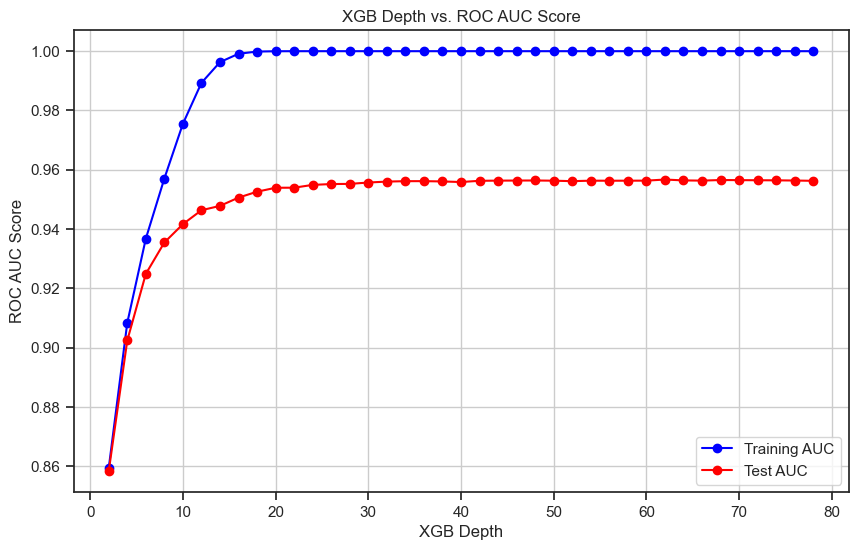

In [213]:
# check overfitting

# List to store AUC values
train_auc = []
test_auc = []

# Range of depths to evaluate
depth_range = np.arange(2, 80, 2)

# Loop over each depth
for depth in depth_range:
    # Initialize Decision Tree with the current max depth
    xgb = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=depth,
    learning_rate=best_params['learning_rate'],
    enable_categorical = best_params['enable_categorical'],
    random_state=best_params['random_state']
    )
    
    # Fit the model on training data
    xgb.fit(X_train_2[selected_features], y_train_2)
    
    # Predict probabilities for the ROC AUC calculation
    y_train_pred_prob_2 = xgb.predict_proba(X_train_2[selected_features])[:, 1]
    y_test_pred_prob_2 = xgb.predict_proba(X_test_2[selected_features])[:, 1]
    
    # Calculate ROC AUC for both training and test sets
    train_auc.append(roc_auc_score(y_train_2, y_train_pred_prob_2))
    test_auc.append(roc_auc_score(y_test_2, y_test_pred_prob_2))

# Plotting the ROC AUC scores for training and validation sets
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_auc, label='Training AUC', marker='o', color='blue')
plt.plot(depth_range, test_auc, label='Test AUC', marker='o', color='red')

# Adding labels and title
plt.xlabel('XGB Depth')
plt.ylabel('ROC AUC Score')
plt.title('XGB Depth vs. ROC AUC Score')
plt.legend()
plt.grid(True)
plt.show()

### Observation
- We see the model begins to overfit on the training set at max_depth > 12, hence we will set this parameter to a modest 12

In [234]:
# Specifying our New model, with selected features and does NOT overfit. 
# New 'best' Model_2 with best parameters
best_model_2 = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth = 12,
    learning_rate=best_params['learning_rate'],
    enable_categorical = best_params['enable_categorical'],
    random_state=best_params['random_state']
)

# Performing 5-Fold Cross-Validation
cv_score_best_new = cross_val_score(best_model_2, X_2[selected_features], y_2, cv=5, scoring='accuracy')

print(f"\n 5-Fold CV Scores New selected no Overfit = {cv_score_best_new}")
print(f"\n Average - 5-Fold CV Scores New selected no Overfit = {cv_score_best_new.mean()}")
print(f"\n Median - 5-Fold CV Scores New selected no Overfit = {np.median(cv_score_best_new)}")

# Fit the 'best' model_2 on the training data
best_model_2.fit(X_train_2[selected_features], y_train_2)

# Predict on the test set
y_pred_2 = best_model_2.predict(X_test_2[selected_features])
y_prob_2 = best_model_2.predict_proba(X_test_2[selected_features])[:,1]


 5-Fold CV Scores New selected no Overfit = [0.67769209 0.91973493 0.91590734 0.92567625 0.91987775]

 Average - 5-Fold CV Scores New selected no Overfit = 0.8717776703585478

 Median - 5-Fold CV Scores New selected no Overfit = 0.9197349253049216


# 6. Model Evaluations & Comparisons

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

  ... Evaluation metrics for Legacy LogisticRegression Model ... 
Accuracy: 0.87835
Precision: 0.0
Recall (Sensitivity): 0.0
F1-Score: 0.0
ROC-AUC: 0.6173932969589436
Confusion Matrix:
[[17567     0]
 [ 2433     0]]


c:\Users\cpitt\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


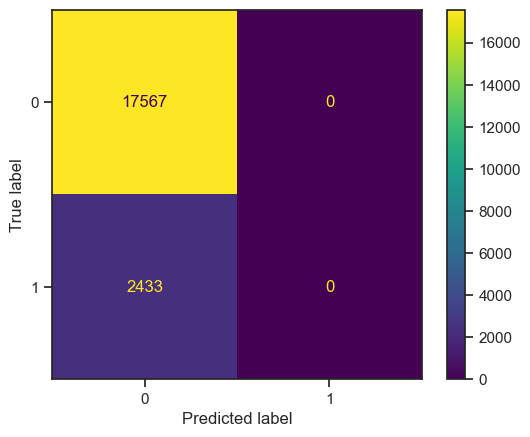


  ... Evaluation metrics for New XGBoost Model_2 ... 
Accuracy: 0.8809483004855756
Precision: 0.911744738628649
Recall (Sensitivity): 0.8436411398549483
F1-Score: 0.8763718336596072
ROC-AUC: 0.9463448214401338
Confusion Matrix:
[[16069  1430]
 [ 2738 14773]]


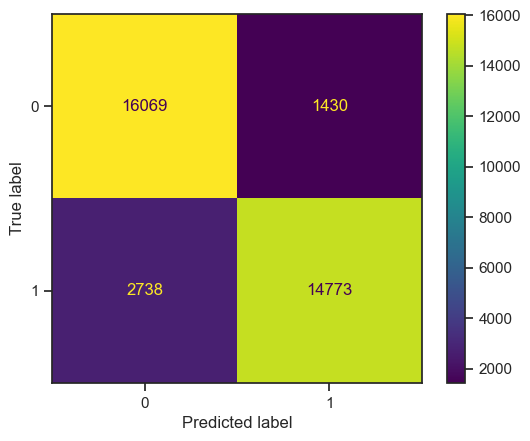


  ... Confusion Matrix for reference  ... 


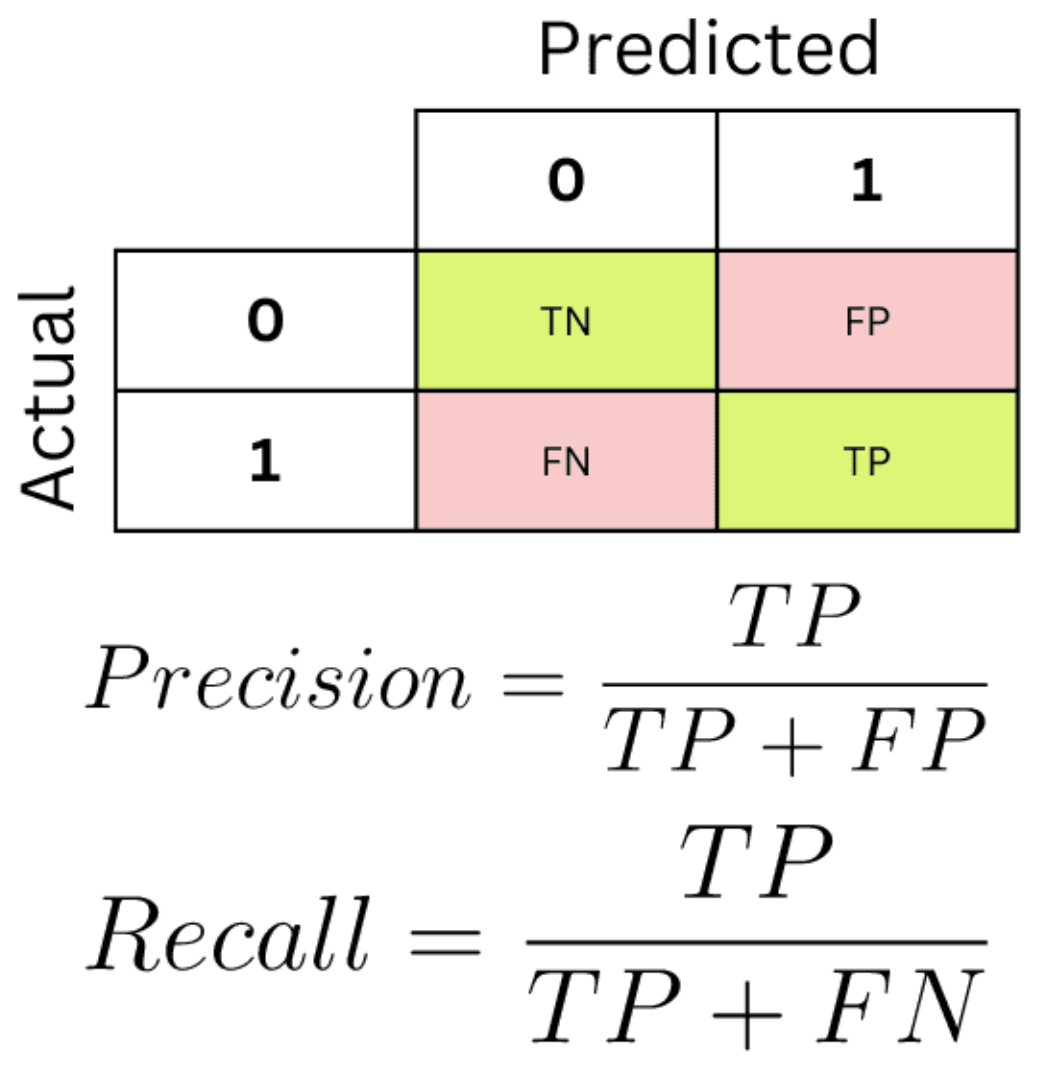

In [235]:
# To Re-load cell when making a change to the model_evaluations library
%load_ext autoreload
%autoreload 2

from model_evaluations import model_evaluation_report_classification

print("\n  ... Evaluation metrics for Legacy LogisticRegression Model ... ")
model_evaluation_report_classification(X_test, y_test, y_pred, y_prob)

print("\n  ... Evaluation metrics for New XGBoost Model_2 ... ")
model_evaluation_report_classification(X_test_2, y_test_2, y_pred_2, y_prob_2)

from IPython.display import Image
print("\n  ... Confusion Matrix for reference  ... ")
Image(filename=f"{path_python_material}/images/confusion_matrix_v2.png", width=500,)

### Observation

- **TN** = predicted[0], Actual[0] = loan_default False when it is actually False
- **TP** = predicted[1], Actual[1] = loan_default True when it is actually True
- **FP** = predicted[1], Actual[0] = loan default True when it is actually False
- **FN** = predicted[0], Actual[1] = loan default False when it is actually True

- **Legacy model**
    - We can see from the confusion matrix (Top-Left = TN), it achieves a high number ~17500 in predicting these correctly (i.e., loan_default = False when it is actually False). 

    - However, it performs terribily in predicting (Bottom-right = TP) (i.e., loan_defaults = True when it is actually True) where it predicted a total of zero.
    
    - As for the (Top-Right = FP), also predicted a total of zero, which makes sense as it predicted a high number of TN, 
    
    - As for the (Bottom-Left = FN), it predicted ~2400 records to have loan_defaults=False when they were actually True.
    
    - Hence Precision and Recall = 0, due to number of TP = 0, resulting ROC_AUC score ~ 62%, entails it will distinguish between loan_defaults [True, False] 62% of the time.

- **New model_2**
    - We can see from the confusion matrix (Top-Left = TN), it achieves a high number ~ 16000 in predicting these correctly (i.e., loan_default = False when it is actually False). 

    - However, it performs very well in predicting (Bottom-right = TP) (i.e., loan_defaults = True when it is actually True) where it predicted a total of ~ 14700.
    
    - As for the (Top-Right = FP), it predicted a total of ~1400 (~ <10% of the TN and TP) 
    
    - As for the (Bottom-Left = FN), it predicted ~2700 records to have loan_defaults=False when they were actually True.
    
    - Hence Precision = 91% and Recall (Sensitivity) =81% , resulting ROC_AUC score ~ 94%, entails it will distinguish between loan_defaults [True, False] 94% of the time.

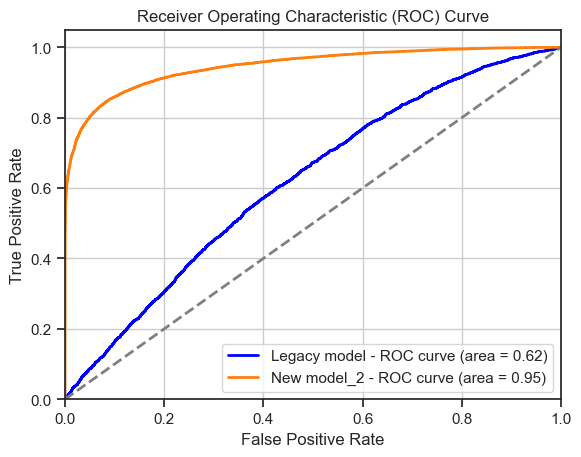

Legacy model - ROC AUC Score: 0.62
New model_2 - ROC AUC Score: 0.95


In [238]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Compute ROC curve and ROC AUC

# - Legacy model 'balanced
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# - New model_2 
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test_2, y_prob_2)
roc_auc_2 = auc(fpr_2, tpr_2)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Legacy model - ROC curve (area = {roc_auc:.2f})')
plt.plot(fpr_2, tpr_2, color='#ff7f0e', lw=2, label=f'New model_2 - ROC curve (area = {roc_auc_2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random prediction)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Additional stats
print(f'Legacy model - ROC AUC Score: {roc_auc_score(y_test, y_prob):.2f}')

# Additional stats
print(f'New model_2 - ROC AUC Score: {roc_auc_score(y_test_2, y_prob_2):.2f}')

# Part 2. Custom Loss Function Implementation and Optimisation (Optional)

### **Background**
As a data scientist working for the business, your objective is to **minimize the average cost of default** and **maximize the average income on loans**. Optimise `model_2` on this basis, leveraging a **custom loss function** (see 7.2 below) and considering the **following information on the cost of misclassifying** unseen observations:
##### Misclassification cost, and importance of False Positives and False Negatives:
-   **False Positives (FP)**: Predicting a loan as default when it is not. This can lead to lost opportunities for the lender since a potentially profitable loan is denied. Given the **FP_cost = 100**, the cost is relatively low, but it can accumulate over multiple instances.

-   **False Negatives (FN)**: Predicting a loan as non-default when it actually defaults. This is much more severe because it results in financial loss to the lender. Given the **FN_cost = 1000**, the cost here is much higher, reflecting the significant impact of a loan defaulting when it was predicted otherwise.

In [239]:
# Using the New 'best' model_2 

# Features to utilise from model_2

# Initial target ['loan_default'] with values [True, False]
y # Legacy model
y_2 # model_2

# the predicted ['loan_default'] on full dataset 
y_pred_full = model.predict(X) # Legacy
y_pred_full_2 = best_model_2.predict(X_2[selected_features]) # model_2

# Predictions probabilities on full data
y_prob_full = model.predict_proba(X)[:,1] # Legacy
y_prob_full_2 = best_model_2.predict_proba(X_2[selected_features])[:,1] # model_2

# Default threshold
threshold = 0.5

# Custom thresholding based on custom loss function
FP_cost = 1.0  # Cost for False Positive
FN_cost = 5.0  # Cost for False Negative

def custom_threshold(y_pred_prob, threshold):
    return np.where(y_pred_prob > threshold, 1, 0)

def evaluate_custom_loss(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    loss = FP_cost * fp + FN_cost * fn
    return loss

# Calculate loss for the default threshold - Legacy
y_pred_default = custom_threshold(y_prob_full, threshold)
default_loss = evaluate_custom_loss(y, y_pred_default)

# Calculate loss for the default threshold - Model_2
y_pred_default_2 = custom_threshold(y_prob_full_2, threshold)
default_loss_2 = evaluate_custom_loss(y_2, y_pred_default_2)

print(f"Default Loss Legacy Model: {default_loss}")
print(f"\n Default Loss Model_2: {default_loss_2}")

# Custom loss function
FP_cost = 100  # Cost for False Positive
FN_cost = 1000  # Cost for False Negative

def custom_loss(y_true, y_pred, threshold):
    y_pred_bin = (y_pred > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    cust_loss = FP_cost * fp + FN_cost * fn
    return cust_loss

# Evaluate model for various thresholds
thresholds = np.arange(0.1, 0.9, 0.01)

# Losses for Legacy
losses = [custom_loss(y, y_pred_full, t) for t in thresholds]

# Losses for Model_2
losses_2 = [custom_loss(y_2, y_pred_full_2, t) for t in thresholds]

# Select the threshold with the minimum loss - Legacy
best_threshold = thresholds[np.argmin(losses)]
best_loss = min(losses)

# Select the threshold with the minimum loss - Model_2
best_threshold_2 = thresholds[np.argmin(losses_2)]
best_loss_2 = min(losses_2)

print("\n -- Evaluation Losses for - Legacy Model")
print(f"Best Threshold: {best_threshold}")
print(f"Lowest Custom Loss: {best_loss}")

print("\n -- Evaluation Losses for - New Model_2")
print(f"Best Threshold: {best_threshold_2}")
print(f"Lowest Custom Loss: {best_loss_2}")


Default Loss Legacy Model: 61921.0

 Default Loss Model_2: 46266.0

 -- Evaluation Losses for - Legacy Model
Best Threshold: 0.1
Lowest Custom Loss: 12384100

 -- Evaluation Losses for - New Model_2
Best Threshold: 0.1
Lowest Custom Loss: 8954100


# Part 3. PoC to Predict 'loan_amnt' using a regression model (Optional)

- Features to include
    - 'emp_length'
    - 'home_ownership'
    - 'annual_inc'

- Additional Features
    - 'purpose' = 'Purpose of Loan'
    - 'term' = Term length of Loan
    - 'int_rate_clean' = Interest rate of a Loan
    - 'max_bal_bc' = Maximum current balance owed on all revolving accounts, can entail what loan_amount they can borrow
    - 'total_bc_limit' = Total bankcard high credit/credit limit, borrowers credit limit can show how much more they can borrow.
    - 'num_actv_bc_tl' = Number of currently active bankcard accounts, can show activity of money flow in a borrower's account, which can tell us how much they are capable of borrowing
    - 'num_bc_sats' = Number of satisfactory bankcard accounts, can show satisfactory activity of money flow in a borrower's accounts, which can tell us how much they are capable of borrowing
    - 'tot_cur_bal = 'Total Current balane of all acounts

- Target Feature
    - 'loan_amnt'
    

In [180]:

# 0. Import Data
# Read data that was exported from previous session
df = pd.read_csv(f"{path_python_material}/data/2-intermediate/df_out_dsif3.csv")

# print shape of dataFrame
(print(f"shape of df = {df.shape}"))

# 1.0 Feature Selection
feat_sel = [
    'emp_length',
    'home_ownership',
    'annual_inc',

    'purpose',
    'term',
    'int_rate_clean',
    'max_bal_bc',
    'total_bc_limit',
    'num_bc_tl',
    'num_actv_bc_tl',
    'num_bc_sats',
    'tot_cur_bal',
    'loan_amnt'
]

df_feat_sel = df[feat_sel].drop_duplicates().reset_index(drop=True)

#display(df_feat_sel)

print("\n Checking emp_length value counts")
display(df_feat_sel['emp_length'].value_counts())

print("\n Quick Stats on  emp_length")
display(df_feat_sel['emp_length'].describe())

# Splitting the features between Numerical and Categorical

# Features Numerical
feat_num = [
    'annual_inc',
    'int_rate_clean',
    'max_bal_bc',
    'total_bc_limit',
    'num_bc_tl',
    'num_actv_bc_tl',
    'num_bc_sats',
    'tot_cur_bal'
]

# Features Categorical
feat_cat = [
    'emp_length',
    'home_ownership',
    'annual_inc',
    'purpose',
    'term'
]

# Features Target
feat_tar = ['loan_amnt']

# 2.0 Feature Engineering

# Dropping records with annual_inc <= £1.0
df_feat_sel = df_feat_sel[df_feat_sel['annual_inc'] >= 1.0].reset_index(drop=True) # ensuring to reset_index of DataFrame

# Fixing the NaN values with mode (most common value)
emp_length_mode = df_feat_sel['emp_length'].mode()

# Replace the NaN values with the mode
print("\n Replacing the NaN values with the mode for emp_length")
df_feat_sel['emp_length'] = df_feat_sel['emp_length'].apply(lambda x : emp_length_mode.values[0] if pd.isnull(x) == True else x)


X_feat_num = df_feat_sel[feat_num]
X_feat_cat = df_feat_sel[feat_cat]

y_tar = df_feat_sel[feat_tar]

print("\n Quick Stats checking numerical features")
display(df_feat_sel.describe())

print("\n We can see fields ['max_bal_bc', 'total_bc_limit', 'num_bc_tl', 'num_actv_bc_tl', 'num_bc_sats', 'tot_cur_bal']")
print(" ... Need to be populated, hence we will impute the mean for each of those fields")

#fields_to_fix = max_bal_bc	total_bc_limit	num_bc_tl	num_actv_bc_tl	num_bc_sats	tot_cur_bal

# Create an imputer (replace missing values with the mean of the column)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer, for columns with NaN, filling them with their 'mean' value
X_feat_num = imputer.fit_transform(X_feat_num , )

# Converting results of imputer into a dataframe
X_feat_num = pd.DataFrame(X_feat_num, columns=feat_num)

print("\n Quick Stats checking numerical features ... After Imputing the mean \n")
display(X_feat_num.describe())


# Standardizing the numerical data
scaler = StandardScaler()

X_feat_num_std = scaler.fit_transform(X_feat_num)

X_feat_num_std = pd.DataFrame(X_feat_num_std, columns=feat_num)

# Encoding categorical data
# One-hot encoding
X_feat_cat_ohe = pd.get_dummies(X_feat_cat)

# Combining Numerical and Categorical features
X_feat = pd.concat([X_feat_num_std, X_feat_cat_ohe] , axis=1)

print("Sample of featured Engineered / transformed dataset ready for our ML  \n")

df_transformed = pd.concat([X_feat,y_tar] , axis=1)

display(df_transformed)

# 4.0 Data Splitting

# Split the data into training and testing sets (returns pandas dfs)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_feat, y_tar, test_size=0.2, random_state=42)

for dframe in [X_reg_train, X_reg_test, y_reg_train, y_reg_test]:
    print(f"Shape: {dframe.shape}")

# 5.0 Model Selection (LinearRegression)
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression()

# 6.0 Feature Selection using RFE
# Apply Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE

reg_rfe = RFE(estimator=reg_model,
          n_features_to_select=20, # number of features to select
          step=30,                  # step=1 means remove one feature at a time
          verbose = 3)

# Fit RFE to the training data
reg_rfe.fit(X_reg_train, y_reg_train)

## Feature Selecting using Recursive Feature Elimination (RFE) for New model_2
selected_features_reg = X_reg_train.columns[reg_rfe.support_] # rfe.support_ represents the mask of selected features (i.e. boolean indicator) 

print("\n Selected Features for Regression by RFE:")
print(f"Number of Selected Features {len(selected_features_reg.values)} ")
print(f"\n {selected_features_reg.values}")

# Fitting / Training new model with selected Features
new_reg_feat_select_model = LinearRegression()
new_reg_feat_select_model.fit(X_reg_train[selected_features_reg.values] , y_reg_train)


# 7.0 Cross-Validation Scoring, using R^2 scoring

reg_cv_scores = cross_val_score(new_reg_feat_select_model, X_feat[selected_features_reg], y_tar, cv=5, scoring='r2')

print(f'\n Cross-Validation R^2 Scores: {reg_cv_scores}')
print(f'Mean CV R^2 Score: {reg_cv_scores.mean()}')
print(f'Median CV R^2 Score: {np.median(reg_cv_scores)}')

# 8.0 Perform Predictions
y_reg_pred = new_reg_feat_select_model.predict(X_feat[selected_features_reg])

# 9.0 Evaluating model metrics
from model_evaluations import model_evaluation_report_regression

# n = count of rows in your dataset used for train or test
# p = count of independent variables
n = df_transformed.shape[0]
p = len(selected_features_reg)

model_evaluation_report_regression(y_tar, y_reg_pred, n , p)



shape of df = (100000, 159)

 Checking emp_length value counts


10+ years    32207
< 1 year      9306
2 years       9014
3 years       7862
1 year        6714
5 years       6158
4 years       6009
6 years       4496
7 years       4051
8 years       3919
9 years       3314
Name: emp_length, dtype: int64


 Quick Stats on  emp_length


count         93050
unique           11
top       10+ years
freq          32207
Name: emp_length, dtype: object


 Replacing the NaN values with the mode for emp_length

 Quick Stats checking numerical features


,annual_inc,int_rate_clean,max_bal_bc,total_bc_limit,num_bc_tl,num_actv_bc_tl,num_bc_sats,tot_cur_bal,loan_amnt
count,9.990000e+04,99900.000000,70256.000000,98122.000000,97462.000000,97462.000000,97849.000000,9.746200e+04,99900.000000
mean,8.010929e+04,13.055579,5997.667644,24823.207415,7.637110,3.703166,4.858997,1.459141e+05,15326.746496
std,8.723121e+04,4.875821,5511.621785,24432.912902,4.694183,2.380807,3.116618,1.644374e+05,9464.498876
min,1.000000e+00,5.310000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,700.000000
25%,4.750000e+04,9.170000,2347.750000,8900.000000,4.000000,2.000000,3.000000,2.973000e+04,8000.000000
50%,6.600000e+04,12.490000,4568.000000,17500.000000,7.000000,3.000000,4.000000,8.093700e+04,13000.000000
75%,9.500000e+04,16.010000,7909.000000,32500.000000,10.000000,5.000000,6.000000,2.180650e+05,20000.000000
max,1.099920e+07,30.990000,94246.000000,425150.000000,59.000000,50.000000,59.000000,4.035706e+06,40000.000000



 We can see fields ['max_bal_bc', 'total_bc_limit', 'num_bc_tl', 'num_actv_bc_tl', 'num_bc_sats', 'tot_cur_bal']
 ... Need to be populated, hence we will impute the mean for each of those fields

 Quick Stats checking numerical features ... After Imputing the mean 



,annual_inc,int_rate_clean,max_bal_bc,total_bc_limit,num_bc_tl,num_actv_bc_tl,num_bc_sats,tot_cur_bal
count,9.990000e+04,99900.000000,99900.000000,99900.000000,99900.000000,99900.000000,99900.000000,9.990000e+04
mean,8.010929e+04,13.055579,5997.667644,24823.207415,7.637110,3.703166,4.858997,1.459141e+05
std,8.723121e+04,4.875821,4622.079985,24214.508552,4.636549,2.351576,3.084459,1.624185e+05
min,1.000000e+00,5.310000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,4.750000e+04,9.170000,3234.000000,9000.000000,4.000000,2.000000,3.000000,3.043675e+04
50%,6.600000e+04,12.490000,5997.667644,17900.000000,7.000000,3.000000,4.000000,8.628950e+04
75%,9.500000e+04,16.010000,6164.000000,32100.000000,10.000000,5.000000,6.000000,2.141928e+05
max,1.099920e+07,30.990000,94246.000000,425150.000000,59.000000,50.000000,59.000000,4.035706e+06


Sample of featured Engineered / transformed dataset ready for our ML  



,annual_inc,int_rate_clean,max_bal_bc,total_bc_limit,num_bc_tl,num_actv_bc_tl,num_bc_sats,tot_cur_bal,annual_inc,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months,loan_amnt
0,-0.368096,0.005009,-1.297619e+00,-1.025143,-1.431483,-1.574767,-1.575324,0.696414,48000.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,4000.0
1,-0.264921,-0.798962,-8.352705e-01,-0.488272,-0.353090,-0.299021,0.045714,-0.517795,57000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,24000.0
2,-0.287849,-0.526187,3.935454e-16,-0.612165,-1.000126,-0.299021,-0.602701,0.081376,55000.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5000.0
3,-0.419683,-0.411334,-8.166640e-01,0.998447,1.803698,0.976726,1.990960,-0.254431,43500.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,24000.0
4,-0.368096,0.109607,-4.523241e-01,0.164233,-0.353090,0.126228,0.045714,-0.342703,48000.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,14000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99895,-0.230530,-0.321092,1.393607e+00,0.329424,-0.353090,0.126228,0.045714,-0.723302,60000.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,3300.0
99896,0.801216,-0.667702,-5.576884e-01,0.453317,2.450734,0.976726,3.287791,-0.659861,150000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,6000.0
99897,-0.368096,1.422213,-7.781531e-01,-0.636944,0.509625,0.126228,-0.278493,-0.766352,48000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,10000.0
99898,0.113386,-0.870746,7.298336e-01,1.180158,1.803698,1.401975,1.342545,1.676794,90000.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,10625.0


Shape: (79920, 42)
Shape: (19980, 42)
Shape: (79920, 1)
Shape: (19980, 1)
Fitting estimator with 42 features.

 Selected Features for Regression by RFE:
Number of Selected Features 20 

 ['max_bal_bc' 'total_bc_limit' 'tot_cur_bal' 'home_ownership_MORTGAGE'
 'home_ownership_NONE' 'home_ownership_OTHER' 'purpose_car'
 'purpose_credit_card' 'purpose_debt_consolidation' 'purpose_educational'
 'purpose_home_improvement' 'purpose_house' 'purpose_major_purchase'
 'purpose_medical' 'purpose_moving' 'purpose_renewable_energy'
 'purpose_small_business' 'purpose_vacation' 'term_ 36 months'
 'term_ 60 months']

 Cross-Validation R^2 Scores: [0.34580892 0.34272397 0.33262299 0.33193121 0.33432725]
Mean CV R^2 Score: 0.33748286851648235
Median CV R^2 Score: 0.3343272465035886

 ... Evaluation Metrics for Regression ... 
MAE: 5979.226608425215
MSE: 59321171.64166949
RMSE: 7702.023866599577
R-squared: 0.3377547995351151
Adjusted R-squared: 0.3376288217737131


C:\Users\cpitt\AppData\Local\Temp\ipykernel_20464\1647903354.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left",fontsize = 20)


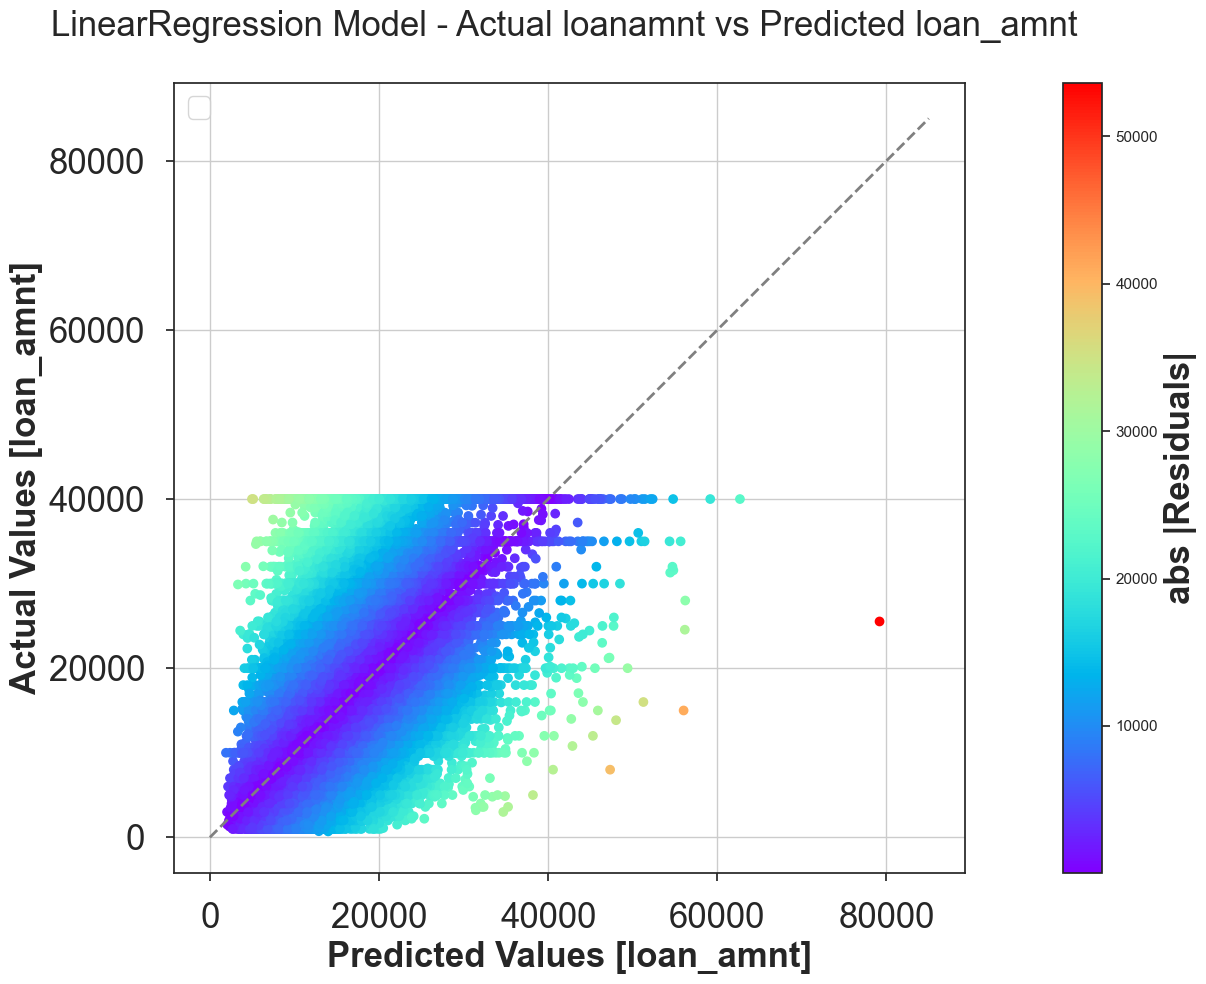

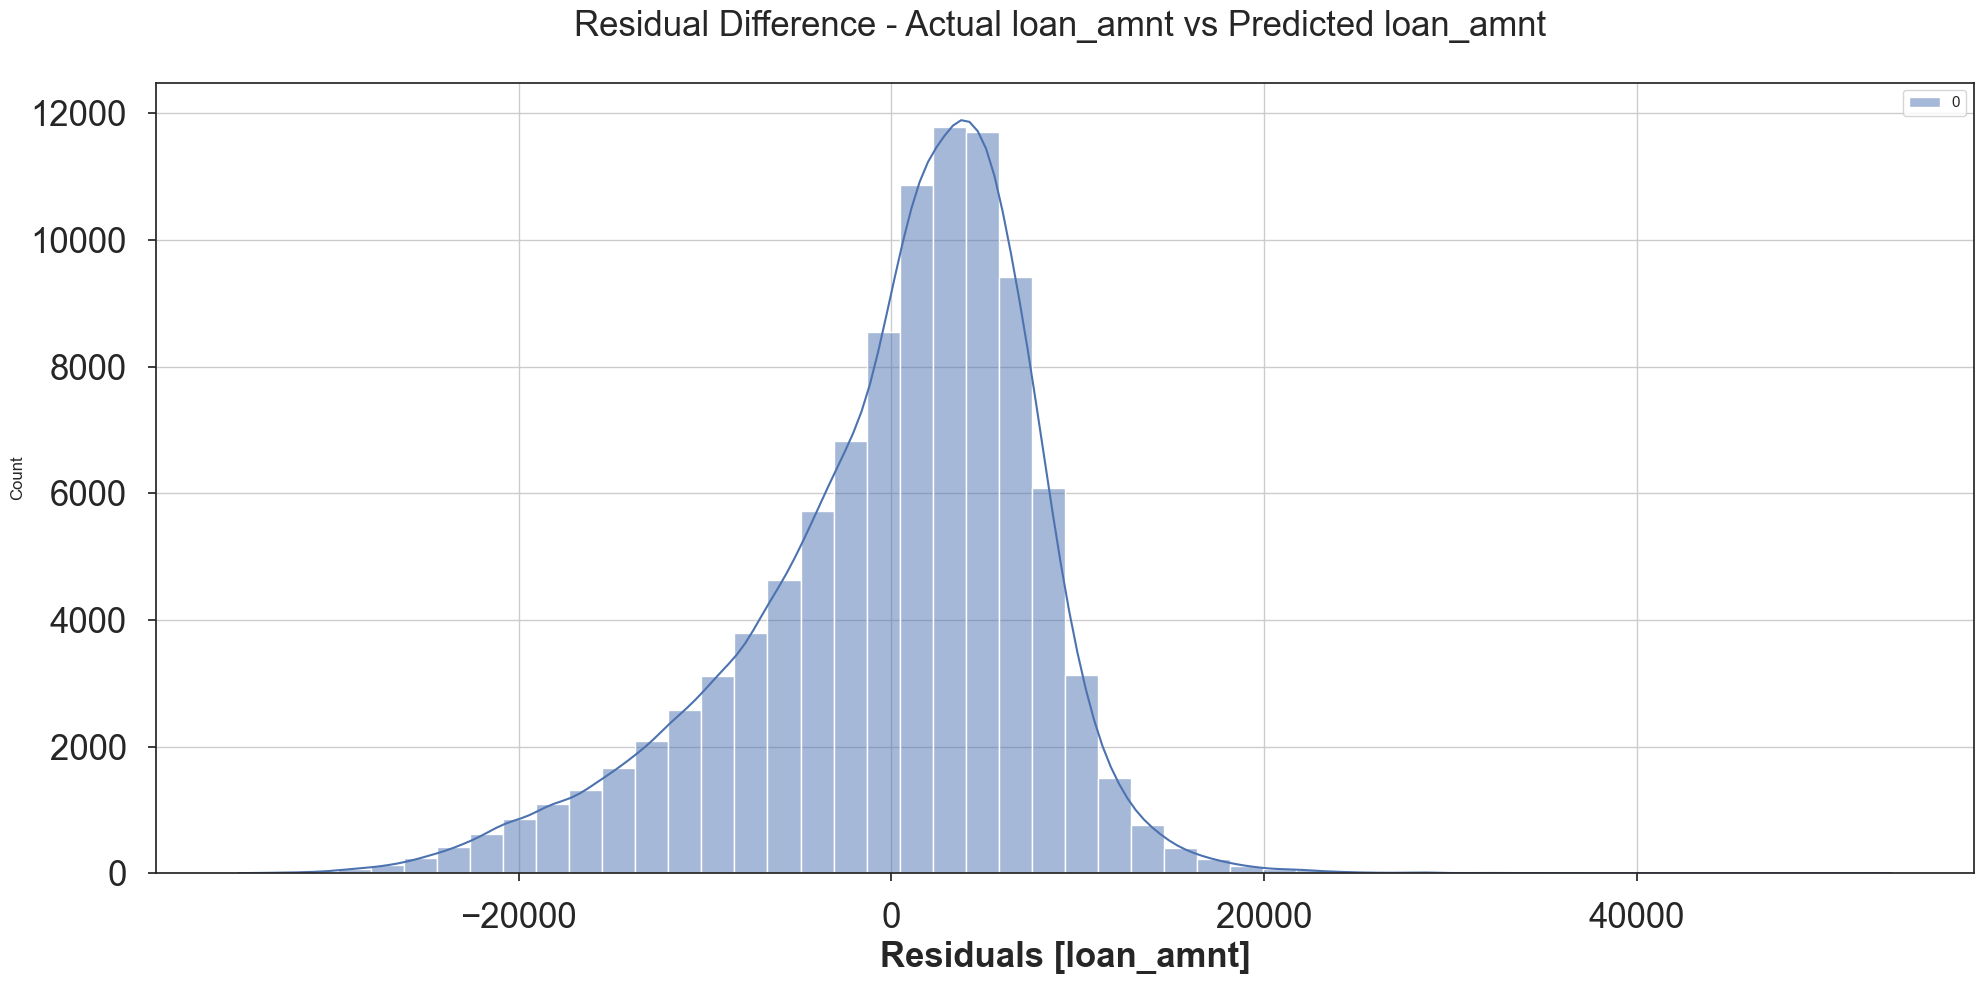

In [204]:
import seaborn as sns

# Actual Values vs Predicted Values

residuals = y_reg_pred - y_tar.values

plt.figure(figsize=(20,10))
plt.scatter( y_reg_pred , y_tar.values, c = np.abs(residuals) , cmap='rainbow' )
plt.colorbar().set_label('abs |Residuals|', fontsize=25 , weight='bold')
plt.plot([0, 85e3], [0, 85e3], color='gray', lw=2, linestyle='--')
plt.ylabel('Actual Values [loan_amnt]' , fontsize=25 , weight='bold')
plt.xlabel('Predicted Values [loan_amnt]' , fontsize=25 , weight='bold')
plt.title("LinearRegression Model - Actual loanamnt vs Predicted loan_amnt \n" , fontsize=25)
plt.grid(True)
plt.gca().set_aspect('equal')
plt.tick_params(axis='both', which='major', labelsize=25, pad=15)
plt.legend(loc="upper left",fontsize = 20)
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.tight_layout()
plt.show()


# Residual difference between Actual Values Predicted Values
plt.figure(figsize=(20,10))
sns.set(style="ticks")
sns.histplot(residuals, kde=True, bins=50)
plt.xlabel('Counts' , fontsize=25 , weight='bold')
plt.xlabel('Residuals [loan_amnt]' , fontsize=25 , weight='bold')
plt.title("Residual Difference - Actual loan_amnt vs Predicted loan_amnt \n" , fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25, pad=15)
plt.grid(True)
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.tight_layout()
plt.show()

#### Observation

- **Top-Scatter-Plot :** We can see there are large residuals (differences between Actual vs Predicted) as you move up towards up the 'red' in colour bar.

- **Bottom-Hist-Plot :** We can see the distribution of the residuals, where its peak is skewed to the right, with a broad distribution to its left 